#  Comparing walltime and any other parameters benchmarking + efficiency of components.
## Let's plot a graph to show scalability and efficiency of the systems!
### Mandana Safari

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import glob
import unittest
import copy
import matplotlib.cm as cm
import mpld3
import json

In [4]:
def generate_colormaps(colors_list):
    colormaps = []
    for colors in colors_list:
        normalized_colors = [(int(color[1:3], 16) / 255, int(color[3:5], 16) / 255, int(color[5:7], 16) / 255) for color in colors]
        colormap = mcolors.LinearSegmentedColormap.from_list("", normalized_colors)
        colormaps.append(colormap)
    return colormaps

# Define a list of color tuples for each colormap
colors_list = [("#2EA6A6", "#F28F38"), ("#FF5733", "#33FF57"), ("#FF5733", "#3377FF")]

# Generate colormaps
colormaps = generate_colormaps(colors_list)

# Now colormaps is a list of LinearSegmentedColormap instances

def load_dataframes_plot(dataframes_list,colormaps=None, **kwargs):
    """
    Load dataframes from a list of dictionaries and plot desired quantities.
    
    Args:
        dataframes_list (list): A list of dictionaries where each dictionary containsa dataframe and 
        its associated column name. Also plot the result! it needs to  spesify the type of Plot, the 
        options are: 'runtime_components' and efficiency. user can  spesify the desired colormap! or
        default one in the function.
    
    Returns:
        dict: A dictionary where keys are dataframe names and values are the corresponding dataframes and plot.
        
    Usage:
        load_dataframes(dataframes_list, colormaps=colormaps, plot='runtime_components/efficiency') 
            Where: dataframes_list = [{'filename':'dat_file1', 'column_name':'any_column', 'efficiency':'any_column', 'x_axis':'any_column', 'time_unit':'minute'},
                                      {'filename':'dat_file2', 'column_name':'any_column', 'efficiency':'any_column', 'x_axis':'any_column', 'time_unit':'minute'},
                                      {'filename':'dat_file3', 'column_name':'any_column', 'efficiency':'any_column', 'x_axis':'any_column', 'time_unit':'minute'}, ...]
        
    Author:
        Mandana Safari
    """
    fig, ax = plt.subplots()
    
    if colormaps is None:
        # Define a list of color tuples for each colormap
        colors_list = [("#2EA6A6", "#F28F38"), ("#FF5733", "#33FF57"), ("#FF5733", "#3377FF")]

        # Generate colormaps
        colormaps = generate_colormaps(colors_list)

        
    loaded_dataframes = {}
    n=0
    for num, df_dict in enumerate(dataframes_list, start=1):
        df_name = f'df_{num}'
        dataframe = df_dict
        filename = df_dict['filename']
        time_unit = df_dict['time_unit']
        loaded_dataframes[df_name] = copy.deepcopy(pd.read_csv(filename))  
        
        column_name = df_dict['column_name']
        if column_name not in loaded_dataframes[df_name].columns:
            raise ValueError(f"Error: Column '{column_name}' does not exist in DataFrame '{df_name}'.")
            
        
        efficiency = df_dict['efficiency']
        if efficiency not in loaded_dataframes[df_name].columns:
            raise ValueError(f"Error: Column '{efficiency}' does not exist in DataFrame '{df_name}'.")
            
        x_axis = df_dict['x_axis']
        if x_axis not in loaded_dataframes[df_name].columns:
            raise ValueError(f"Error: Column '{x_axis}' does not exist in DataFrame '{df_name}'.")
            
     
        loaded_dataframes[df_name][f'other components ({df_name})'] = loaded_dataframes[df_name]['walltime'] - loaded_dataframes[df_name][column_name]
        loaded_dataframes[df_name][f'{column_name} of ({df_name})'] = loaded_dataframes[df_name][column_name]
        
                        
        T1 = loaded_dataframes[df_name][efficiency][loaded_dataframes[df_name][x_axis]== loaded_dataframes[df_name][x_axis].min()].values[0]
        Tp = loaded_dataframes[df_name][efficiency].values
        # Calculate speedup and efficiency
        loaded_dataframes[df_name]['speedup'] = T1 / Tp
        loaded_dataframes[df_name][f'efficiency of {efficiency}'] = (T1 / Tp) *( loaded_dataframes[df_name][x_axis].min()/loaded_dataframes[df_name][x_axis]) * 100


        if time_unit == 'second':
            loaded_dataframes[df_name].iloc[:, 3:] /= 1
        elif time_unit == 'minute':
            loaded_dataframes[df_name].iloc[:, 3:] /= 60
        elif time_unit == 'hour':
            loaded_dataframes[df_name].iloc[:, 3:] /= 3600
        else:
            print(f"Error: Invalid time unit '{time_unit}' specified.")
        
        # Add another element named "Plots" with specific columns
        plot_columns1 = [df_dict['x_axis'], f'{column_name} of ({df_name})',f'other components ({df_name})']  # Replace with actual columns
        loaded_dataframes[df_name]['Plot_runtime'] = loaded_dataframes[df_name][plot_columns1].to_dict(orient='records')
        # Add another element named "Plots" with specific columns
        plot_columns2 = [df_dict['x_axis'],f'efficiency of {efficiency}']  # Replace with actual columns
        loaded_dataframes[df_name]['Plot_efficiency'] = loaded_dataframes[df_name][plot_columns2].to_dict(orient='records')

        # Save DataFrame to JSON file
        json_filename = f'{df_name}.json'
        loaded_dataframes[df_name].to_json(json_filename, orient='records')
        
        # Save DataFrame to text file (tab-separated, change separator if needed)
        txt_filename = f'{df_name}.txt'
        loaded_dataframes[df_name].to_csv(txt_filename, sep='\t', index=False)

        #Request for plot of component in barplot  
    
        positions = [i for i in range(len(df_name)-1)]

        if 'plot' in kwargs and isinstance(kwargs['plot'], str):
            if kwargs['plot'] == 'runtime_components':
                loaded_dataframes[df_name][[x_axis,f'{column_name} of ({df_name})',f'other components ({df_name})']].plot.bar(x=x_axis, width=0.2, position=positions[n], rot=0, stacked=True, ax=ax, colormap=colormaps[n], edgecolor = 'black', alpha = 0.75)
            elif kwargs['plot'] == 'efficiency':
                loaded_dataframes[df_name][f'efficiency of {efficiency}'].plot.line( ax=ax , label=f'efficiency of {efficiency} from {df_name}', marker='o', linestyle='--', lw=2.5)
                
            n +=1
            # Plot using Plotly Express
            #fig = px.bar(loaded_dataframes[df_name], x=x_axis, y=[f'{column_name} of ({df_name})', f'other components ({df_name})'],
              #       title=f'Runtime Components for {df_name}', color_discrete_map={f'{column_name} of ({df_name})': 'blue', f'other components ({df_name})': 'orange'})
        


        handles, labels = ax.get_legend_handles_labels()
        #if kwargs['plot'] == 'runtime_components':
         #   del handles[3:4], labels[3:4]
            #labels.append(f'other in {df_name}')
            
        ax.set_axisbelow(True)
        ax.grid(axis='y', ls='--', alpha=0.3)
        ax.legend(handles=handles, labels=labels, loc='best', frameon=False, markerfirst=False)
        ax.set_xlabel(f"Number of {x_axis}")
        ax.set_ylabel(f"Total time of execution $[{time_unit}]$")
        if kwargs['plot'] == 'efficiency':
            ax.set_xlim(-0.05, None )
            plt.savefig("efficiency.pdf")
            # Save the Matplotlib plot as an HTML file using mpld3
            html_path = 'efficiency.html'
            mpld3.save_html(fig, html_path)
        else:
            ax.set_xlim(-0.5, None )
            plt.savefig("runtime_components.pdf")
            # Save the Matplotlib plot as an HTML file using mpld3
            html_path = 'runtime_components.html'
            mpld3.save_html(fig, html_path)
            
            
    return loaded_dataframes



In [5]:
def dataframes_plot_runtime_and_efficiency(dataframes_list, colormaps=None, **kwargs):
    """
    Load dataframes from a list of dictionaries and plot desired quantities in same frame.
    
    Args:
        dataframes_list (list): A list of dictionaries where each dictionary containsa dataframe and 
        its associated column name. Also plot the result! it needs to  spesify the type of Plot, the 
        options are: 'runtime_components' and efficiency. user can  spesify the desired colormap! or
        default one in the function.
    
    Returns:
        dict: A dictionary where keys are dataframe names and values are the corresponding dataframes and dual plot.
        
    Usage:
        load_dataframes(dataframes_list, colormaps=colormaps, plot=True) 
            Where: dataframes_list = [{'filename':'dat_file1', 'column_name':'any_column', 'efficiency':'any_column', 'x_axis':'any_column', 'time_unit':'minute'},
                                      {'filename':'dat_file2', 'column_name':'any_column', 'efficiency':'any_column', 'x_axis':'any_column', 'time_unit':'minute'},
                                      {'filename':'dat_file3', 'column_name':'any_column', 'efficiency':'any_column', 'x_axis':'any_column', 'time_unit':'minute'}, ...]
        
    Author:
        Mandana Safari
    """
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    if colormaps is None:
        # Define a list of color tuples for each colormap
        colors_list = [("#2EA6A6", "#F28F38"), ("#FF5733", "#33FF57"), ("#FF5733", "#3377FF")]

    # Generate colormaps
    colormaps = generate_colormaps(colors_list)
    
    loaded_dataframes = {}
    n=0
    for num, df_dict in enumerate(dataframes_list, start=1):
        df_name = f'df_{num}'
        dataframe = df_dict
        filename = df_dict['filename']
        time_unit = df_dict['time_unit']
        loaded_dataframes[df_name] = copy.deepcopy(pd.read_csv(filename))  
        
        column_name = df_dict['column_name']
        if column_name not in loaded_dataframes[df_name].columns:
            raise ValueError(f"Error: Column '{column_name}' does not exist in DataFrame '{df_name}'.")
            
        
        efficiency = df_dict['efficiency']
        if efficiency not in loaded_dataframes[df_name].columns:
            raise ValueError(f"Error: Column '{efficiency}' does not exist in DataFrame '{df_name}'.")
            
        x_axis = df_dict['x_axis']
        if x_axis not in loaded_dataframes[df_name].columns:
            raise ValueError(f"Error: Column '{x_axis}' does not exist in DataFrame '{df_name}'.")
            
     
        loaded_dataframes[df_name][f'other components ({df_name})'] = loaded_dataframes[df_name]['walltime'] - loaded_dataframes[df_name][column_name]
        loaded_dataframes[df_name][f'{column_name} of ({df_name})'] = loaded_dataframes[df_name][column_name]
        
        if efficiency in loaded_dataframes[df_name].columns:
                        
            T1 = loaded_dataframes[df_name][efficiency][loaded_dataframes[df_name][x_axis]== loaded_dataframes[df_name][x_axis].min()].values[0]
            Tp = loaded_dataframes[df_name][efficiency].values
            # Calculate speedup and efficiency
            loaded_dataframes[df_name]['speedup'] = T1 / Tp
            loaded_dataframes[df_name][f'efficiency of {efficiency}'] = (T1 / Tp) *( loaded_dataframes[df_name][x_axis].min()/loaded_dataframes[df_name][x_axis]) * 100


        if time_unit == 'second':
            loaded_dataframes[df_name].iloc[:, 3:] /= 1
        elif time_unit == 'minute':
            loaded_dataframes[df_name].iloc[:, 3:] /= 60
        elif time_unit == 'hour':
            loaded_dataframes[df_name].iloc[:, 3:] /= 3600
        else:
            print(f"Error: Invalid time unit '{time_unit}' specified.")
        
        
        #Request for plot of component in barplot  
        positions = [i for i in range(len(df_name)-1)]

        if 'plot' in kwargs:
            loaded_dataframes[df_name][[x_axis,f'{column_name} of ({df_name})',f'other components ({df_name})']].plot.bar(x=x_axis, width=0.2, position=positions[n], rot=0, stacked=True, ax=ax1, colormap=colormaps[n], edgecolor = 'black', alpha = 0.75)
            loaded_dataframes[df_name][f'efficiency of {efficiency}'].plot.line( ax=ax2 , label=f'efficiency of {efficiency} from {df_name}', marker='o', linestyle='--', lw=2.5)
                
        n +=1
                
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        del handles1[3:4], labels1[3:4]

        ax1.set_axisbelow(True)
        ax2.set_axisbelow(True)
        ax1.grid(axis='y', ls='--', alpha=0.3)
        ax1.legend(handles=handles1, labels=labels1, loc='best', frameon=False, markerfirst=False)
        ax2.legend(handles=handles2, labels=labels2, bbox_to_anchor=( 0.8, 1.16), frameon=False, markerfirst=False)

        ax1.set_xlabel(f"Number of {x_axis}")
        ax1.set_ylabel(f"Total time of execution $[{time_unit}]$")
        ax2.set_ylabel("Efficiency (%)", rotation=270, labelpad=10)
        ax2.set_xlim( - 0.5, None )
        ax1.set_xlim( - 0.5, None )
        ax2.set_ylim( 0, 105)

        plt.savefig("runtime_efficiency.pdf")
        # Save the Matplotlib plot as an HTML file using mpld3
        html_path = 'runtime_efficiency.html'
        mpld3.save_html(fig, html_path)
    
    
    return loaded_dataframes



{'df_1':    Nodes  Tasks/Node  Threads/Task  electrons  cbands  cdiaghg  vloc_psi  \
 0      1           4             8      53.25   42.58    10.13     10.86   
 1      2           4             8      50.65   41.54    10.60     15.86   
 2      4           4             8      46.72   38.81    11.12     15.42   
 
    h_psi  walltime  other components (df_1)  electrons of (df_1)   speedup  \
 0  15.30     60.02                     6.77                53.25  1.000000   
 1  20.46     56.57                     5.92                50.65  1.051333   
 2  20.02     55.84                     9.12                46.72  1.139769   
 
    efficiency of electrons                                       Plots  
 0               100.000000  {'Nodes': 1, 'electrons of (df_1)': 53.25}  
 1                52.566634  {'Nodes': 2, 'electrons of (df_1)': 50.65}  
 2                28.494221  {'Nodes': 4, 'electrons of (df_1)': 46.72}  ,
 'df_2':    Nodes  Tasks/Node  Threads/Task  electrons  cbands  cdi

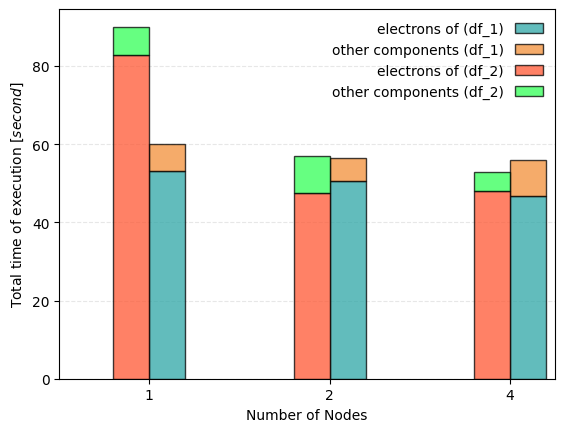

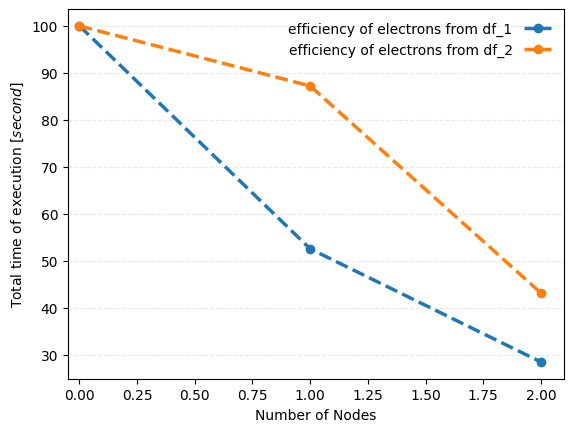

In [6]:
# Specify the filenames and associated column names
dataframes_list = [
    {'filename': '/home/mandanas/1-CINECA-projects/benchmark/benchmark_10it/bench_7.2dev_gpua_iter/000000/result/result.dat', 'column_name': 'electrons', 'efficiency':'electrons', 'x_axis':'Nodes', 'time_unit':'second'},
    {'filename': '/home/mandanas/1-CINECA-projects/benchmark/benchmark_10it/bench_7.2dev_nogpua_iter/000000/result/result.dat', 'column_name': 'electrons', 'efficiency':'electrons', 'x_axis':'Nodes','time_unit':'second'},
    #{'filename': 'results.dat', 'column_name': 'sth_kernel', 'efficiency':'sth_kernel', 'x_axis':'Nodes', 'time_unit':'second'}
]

# Load dataframes from the list of dictionaries
dataframes = load_dataframes_plot(dataframes_list , colormaps=None, plot='runtime_components')
dataframes = load_dataframes_plot(dataframes_list , colormaps=None, plot='efficiency')
dataframes

In [ ]:
dataframes = dataframes_plot_runtime_and_efficiency(dataframes_list, colormaps=None, plot=True)

In [ ]:
dataframes_list = [
    {'filename': 'results.dat', 'column_name': 'phqscf', 'efficiency':'phqscf', 'x_axis':'Nodes', 'time_unit':'minute'},
    {'filename': 'results1.dat', 'column_name': 'h_psi', 'efficiency':'h_psi', 'x_axis':'Nodes','time_unit':'minute'},
]

# Load dataframes from the list of dictionaries
#dataframes = load_dataframes_plot(dataframes_list , colormaps=None, plot='runtime_components')
dataframes = load_dataframes_plot(dataframes_list , colormaps=None, plot='efficiency')